# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 2 : Propiedades en Venta</center>
## <center>Parte 1</center>
### <center> Grupo 22 </center>
### <center> Integrantes: </center>
##### <center> Federico Martin Forte,  Francisco Sobral,  Ian Klaus von der Heyde,  Juan Pablo Aschieri,  Joaquin Rivero  </center>

# Carga de Datos y librerías

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('always')
from sklearn.model_selection import train_test_split
import shapely.speedups
from sklearn.preprocessing import StandardScaler
from IPython.display import Image
import re

In [3]:
viviendas_train=pd.read_csv('./TP1/Datasets/viviendas_caba_train.csv').copy()
viviendas_test=pd.read_csv('./TP1/Datasets/viviendas_caba_test.csv').copy()

# 1.Procesamiento del Lenguaje Natural

## a) Ampliación del dataset

In [4]:
#dataset.head()
#dataset.minqing_hu()

## b) Modelos

# 2. Redes Neuronales

## Regresión:

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

np.random.seed(1)
tf.random.set_seed(1)

c:\Users\iankl\anaconda3\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:18: DeprecationWarning: Call to deprecated create function FileDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  DESCRIPTOR = _descriptor.FileDescriptor(
c:\Users\iankl\anaconda3\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:36: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _descriptor.FieldDescriptor(
c:\Users\iankl\anaconda3\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:43: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _descriptor.F

In [6]:
viviendas_train.head()

,start_date,end_date,latitud,longitud,barrio,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,geometry
0,2021-12-15,2021-12-25,-34.555049,-58.490513,Saavedra,Departamento,2.0,1.0,58.0,49.0,167113.0,Departamento - Saavedra,POINT (-58.4905135 -34.5550487)
1,2021-05-20,2021-06-05,-34.546991,-58.478553,Saavedra,Departamento,2.0,1.0,48.0,44.0,129000.0,Departamento - Saavedra,POINT (-58.4785532 -34.546991)
2,2021-03-20,2021-04-16,-34.570842,-58.491805,Villa Urquiza,Departamento,2.0,1.0,62.0,58.0,124600.0,Venta Depto 2 amb Anticipo + Cuotas CAC V. Urq...,POINT (-58.4918048 -34.5708421)
3,2021-07-17,2021-10-16,-34.589251,-58.402106,Recoleta,Departamento,3.0,2.0,60.0,60.0,196000.0,Excelente 3 ambientes en venta en Barrio Recoleta,POINT (-58.4021058 -34.5892511)
4,2021-07-02,2022-02-09,-34.626290,-58.437632,Caballito,Departamento,3.0,2.0,67.0,61.0,235000.0,VENTA DEPARTAMENTO 3 AMB. EN CABALLITO,POINT (-58.4376325 -34.6262899)


HACEr ONE HOT ENCODINFG CON LAS COLUMNAS NO NUMERICAs

In [7]:
dataset_trabajo=viviendas_train[['latitud', 'longitud', 'property_rooms', 'property_bedrooms', 'property_surface_total', 'property_surface_covered', 'property_price']]

In [8]:
dataset_trabajo.head()

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
0,-34.555049,-58.490513,2.0,1.0,58.0,49.0,167113.0
1,-34.546991,-58.478553,2.0,1.0,48.0,44.0,129000.0
2,-34.570842,-58.491805,2.0,1.0,62.0,58.0,124600.0
3,-34.589251,-58.402106,3.0,2.0,60.0,60.0,196000.0
4,-34.626290,-58.437632,3.0,2.0,67.0,61.0,235000.0


In [9]:
columnas_predictoras=dataset_trabajo.columns.to_list()
columnas_predictoras.remove('property_price')
columnas_predictoras

['latitud',
 'longitud',
 'property_rooms',
 'property_bedrooms',
 'property_surface_total',
 'property_surface_covered']

In [10]:
variable_predictora="property_surface_total"
#X = surf_tot, Y = price
x_train, x_test, y_train, y_test = train_test_split(dataset_trabajo.loc[:,variable_predictora],dataset_trabajo.loc[:,'property_price'],test_size=0.2)

In [11]:
sscaler=StandardScaler()
sscaler.fit(pd.DataFrame(x_train))

StandardScaler()

In [12]:
x_train_transform=sscaler.transform(pd.DataFrame(x_train))
x_test_transform=sscaler.transform(pd.DataFrame(x_test))

#### Modelo 1

In [13]:
# Creo un modelo Red Neuronal
d_in=1
d_out=1

modelo1 = keras.Sequential([
    keras.layers.Dense(1,input_shape=(d_in,))]) #, activation="relu"

In [14]:
modelo1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [15]:
def plot_regression(modelo,x,y,title="",xlabel="x",ylabel="y"):
    plt.figure()
    
    plt.plot(x,y,"o",label="Valores verdaderos")
    plt.plot(x,modelo.predict(x),"x",label="Valores estimados")
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

1858/1858 [==============================] - 1s 408us/step


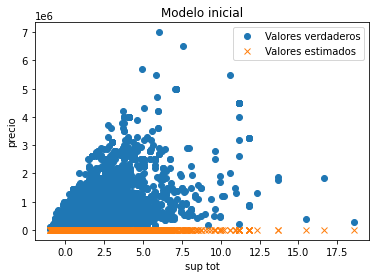

In [16]:
plot_regression(modelo1,x_train_transform,y_train,title=f"Modelo inicial",xlabel="sup tot",ylabel="precio")

In [17]:
modelo1.compile(
  optimizer=keras.optimizers.SGD(learning_rate=0.001), 
  loss='mse', 
  metrics=['mae'], 
)

In [18]:
# Entrenamiento del modelo
#modelo1.fit(x_train_transform,y_train,epochs=100,batch_size=16,verbose=False)

Miremos como la red aprendio los datos con los que fue entrenada

1858/1858 [==============================] - 1s 392us/step


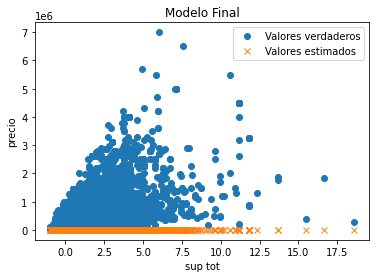

In [19]:
plot_regression(modelo1,x_train_transform,y_train,title=f"Modelo Final",xlabel="sup tot",ylabel="precio")

Miremos como la red predice

465/465 [==============================] - 0s 410us/step


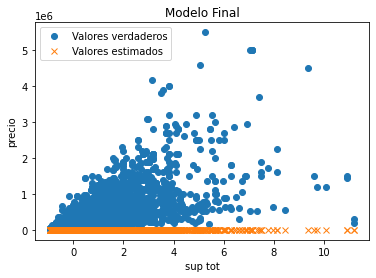

In [20]:
plot_regression(modelo1,x_test_transform,y_test,title=f"Modelo Final",xlabel="sup tot",ylabel="precio")

In [21]:
y_pred_modelo1=modelo1.predict(x_test_transform)

mae_modelo1=mean_absolute_error(y_test,y_pred_modelo1)
mse_modelo1=mean_squared_error(y_test,y_pred_modelo1)

print(f"Error absoluto medio {mae_modelo1}")
print(f"Error cuadrático medio {mse_modelo1}")

465/465 [==============================] - 0s 403us/step
Error absoluto medio 225506.85710933877
Error cuadrático medio 140267338192.15942


#### Modelo 2

In [22]:
# Creo un modelo Red Neuronal
d_in=1
d_out=1

modelo2 = keras.Sequential([
    # input_shape solo en la primer capa
    # Capa con 2 salidas, activación relu
    keras.layers.Dense(2,input_shape=(d_in,), activation="relu"),
    # Capa con 2 salidas, activación tanh
    keras.layers.Dense(2, activation="tanh" ),
    keras.layers.Dense(d_out, )])

In [23]:
modelo2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 2)                 4         
                                                                 
 dense_2 (Dense)             (None, 2)                 6         
                                                                 
 dense_3 (Dense)             (None, 1)                 3         
                                                                 
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


In [24]:
modelo2.compile(
  optimizer=keras.optimizers.SGD(learning_rate=0.001), 
  loss='mse', 
  # metricas para ir calculando en cada iteracion o batch 
  metrics=['mae'], 
)

In [25]:
# Entrenamiento del modelo
modelo2.fit(x_train_transform,y_train,epochs=100,batch_size=16,verbose=False)

Este es el numero de veces que se ejecutaran los algoritmos de forwardpropagation y backpropagation. En cada ciclo (epoch) todos los datos de entrenamiento pasan por la red neuronal para que esta aprenda sobre ellos, si existen 10 ciclos y 1000 datos, cada ciclo los 1000 datos pasaran por la red neuronal. Si se especifica el parametro batch size cada ciclo (epoch) tendra más ejecuciones internas, estas ejecuciones se llaman iteraciones, si tenemos un batch size de 100, se tendran 10 iteraciones para completar un ciclo, en cada iteración se ejecutan los algoritmos de forwardpropagation y backpropagation, de esta manera la red neuronal actualiza más veces los parametros W (pesos) y b (bias).

Verificamos cómo aprendio los datos de entrenamiento

1858/1858 [==============================] - 1s 435us/step


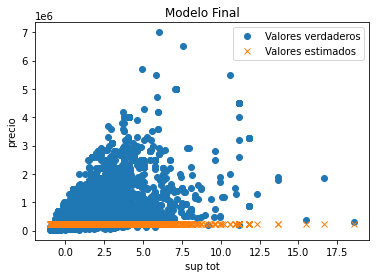

In [26]:
plot_regression(modelo2,x_train_transform,y_train,title=f"Modelo Final",xlabel="sup tot",ylabel="precio")

Evaluamos el modelo en el dataset de test

465/465 [==============================] - 0s 480us/step


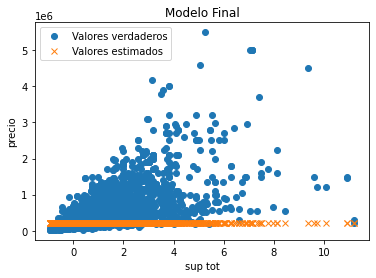

In [27]:
plot_regression(modelo2,x_test_transform,y_test,title=f"Modelo Final",xlabel="sup tot",ylabel="precio")

In [28]:
y_pred=modelo2.predict(x_test_transform)

mae=mean_absolute_error(y_test,y_pred)
mse=mean_squared_error(y_test,y_pred)

print(f"Error absoluto medio {mae}")
print(f"Error cuadrático medio {mse}")

465/465 [==============================] - 0s 477us/step
Error absoluto medio 149479.8232948237
Error cuadrático medio 89427148281.07335


#### Modelo3

465/465 [==============================] - 0s 426us/step


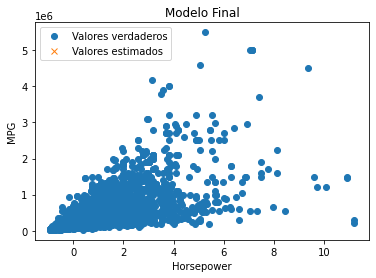

In [29]:
# Creo un modelo Red Neuronal
d_in=1
d_out=1

modelo3 = keras.Sequential([
    # input_shape solo en la primer capa
    # Capa con 2 salidas, activación relu
    keras.layers.Dense(2,input_shape=(d_in,), activation="relu"),
    # Capa con 2 salidas, activación tanh
    keras.layers.Dense(50, activation="relu" ),
    keras.layers.Dense(d_out, )])

modelo3.compile(
  optimizer=keras.optimizers.SGD(learning_rate=0.001), 
  loss='mse', 
  # metricas para ir calculando en cada iteracion o batch 
  metrics=['mae'], 
)

modelo3.fit(x_train_transform,y_train,epochs=100,batch_size=16,verbose=False)

plot_regression(modelo3,x_test_transform,y_test,title=f"Modelo Final",xlabel="Horsepower",ylabel="MPG")

Comparamos con el modelo 2

465/465 [==============================] - 0s 478us/step


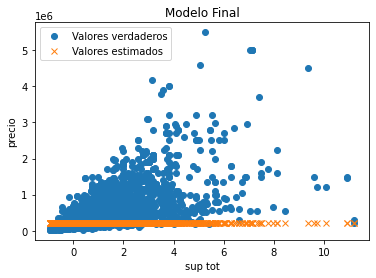

In [30]:
plot_regression(modelo2,x_test_transform,y_test,title=f"Modelo Final",xlabel="sup tot",ylabel="precio")

## Clasificación: